In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import tqdm
tqdm.tqdm.pandas()

In [331]:
import pandas as pd
import geopandas as gpd
import utm
from haversine import haversine
from scipy.spatial import KDTree, cKDTree

In [4]:
DATA_DIR = pathlib.Path("../../data/")

# Loading data

In [5]:
locations = pd.read_csv(DATA_DIR.joinpath("locations.csv"), header=None)

In [6]:
locations.head()

,0,1
0,42.63914,141.62366
1,36.42835,140.61340
2,42.63864,141.62542
3,36.42911,140.61360
4,36.42957,140.61429


In [7]:
locations.columns = ["lat", "lon"]

In [8]:
locations.max()

lat     78.93490
lon    179.82728
dtype: float64

In [9]:
locations.min()

lat    -54.81624
lon   -179.11254
dtype: float64

(just a check that columns are in the correct order)

In [10]:
def get_utm(lat, lon):
    """Calculate UTM coordinates latitude and longitude."""

    easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)
    return pd.Series([easting, northing, zone_number, zone_letter],
                     index=["easting", "northing", "zone_number", "zone_letter"])

if not DATA_DIR.joinpath("locations_utm.csv").exists():
    locations_utm = locations.progress_apply(lambda row: get_utm(row.lat, row.lon), axis=1)
    locations_utm.to_csv(DATA_DIR.joinpath("locations_utm.csv"), index=False)
else:
    locations_utm = pd.read_csv(DATA_DIR.joinpath("locations_utm.csv"))

In [11]:
locations_utm.head()

,easting,northing,zone_number,zone_letter
0,551130.048588,4.720932e+06,54,T
1,465345.985460,4.031530e+06,54,S
2,551274.751185,4.720877e+06,54,T
3,465364.250731,4.031614e+06,54,S
4,465426.304542,4.031665e+06,54,S


In [12]:
locations_utm = locations_utm.join(locations)

# Notation

Given the distance threshold `thr` for connected components calculation, we need the following notation.

## Neighboring zones

Each zone has 8 neighors, we'll mark them as `N, S, E, W, NW, NE, SW, SE` (`Z` is zone of interest, i. e. the one, to which location of interest is located). When dealing with borderline locations, we need to check corresponding neighboring zones.

![Neighboring zones](zones.png)


## Border regions

If a location is near the zone border, we need to consider cross-zone components. All border regions have width of `thr`. If an activity `A` is located border region `N`, we need to check neighboring zone `N` when calculating neighbors of `A`. The full list is the following:

- border region `N` $\rightarrow$ zone `N` (border region `S`)
- border region `S` $\rightarrow$ zone `S` (border region `N`)
- border region `E` $\rightarrow$ zone `E` (border region `W`)
- border region `W` $\rightarrow$ zone `W` (border region `E`)
- border region `N,W` $\rightarrow$ zones `N`, `NW`, `W` (only corresponding border regions)
- border region `S,W` $\rightarrow$ zones `S`, `SW`, `W` (only corresponding border regions)
- border region `N,E` $\rightarrow$ zones `N`, `NE`, `E` (only corresponding border regions)
- border region `S,E` $\rightarrow$ zones `S`, `SE`, `E` (only corresponding border regions)


![Border regions](borders.png)

## Cells

To eliminate unneeded distance checks, we further split each zone into equal cells of size `thr x thr`. Then, at most 9 cells must be checked when seaarching for activity neighbors (some of them may be in a border region of neighboring zone).

![Cells](cells.png)

# Connected components algorithm

## Pre-calculated/pre-filled values

Given a dataframe of `(lat, lon)` locations, we need the following for each location:

- **UTM coordinates** (Pandas dataframe, columns are `["easting", "northing", "zone_number", "zone_letter"]`),
- **borderline status** (`["north", "south", "east", "west"]`, only two can be `True` at max),
- **grid cell tuple** (based on chosen threshold, `["cell_easting", "cell_northing"]`).
- **connected component index column** (filled with `-1`), locations marked as `-1` are considered 

## Algorithm

`S` - all locations, `idx` - current component index.

```
procedure mark(location, component_idx)
    calculate candidate cells [C]
    calculate unmarked neighboring locations [NL] given [C]

    foreach l in [NL]:
        mark l with component_idx
        mark(l, component_idx)

idx = -1

while (have unmarked locations in S)
    idx += 1
    select random unmarked location L
    mark(L, idx)
```

## Convenience routines

### Border status

There are two ways to calculate if a location is near the zone border. First, we know zone borders (by `lat` and `lon`). Zone border in UTM coordinates is not a fixed value, though. Hence, we should work in `lat,lon` representation.

#### Distance from meridian zone border

In this case latitude is fixed: for a point $\varphi_0,\lambda_0$ in zone $\varphi_{min},\lambda_{min}, \varphi_{max},\lambda_{max}$ we calculate distances between $\varphi_0,\lambda_0$ and $\varphi_{0},\lambda_{min}$ and $\varphi_{0},\lambda_{max}$ (at the same latitude). Haversine distance is:

$$
d_h = 2r\arcsin\cos\varphi_0 \sin\frac{\delta\lambda}{2}.
$$

We know, however, the approximate distance:

$$
d_a = r\cos\varphi_0 \delta\lambda.
$$

It turns out, that the difference is negligible (and rightfully so, as we're talking about UTM coordinates, which are designed to have small error in distances).

![Border distance error](border-distance-error.png)

#### Distance from latitude zone border

We calculate distance between $\varphi_0,\lambda_0$ and $\varphi_{min},\lambda_{0}$ and $\varphi_{max},\lambda_{0}$. This one is exact:

$$
d_h = r\delta\varphi.
$$

Hence, we can use the following formulas:

$$
d_{lat} = r\cos\varphi_0 \delta\lambda,
$$
$$
d_{lon} = r\delta\varphi.
$$


In [13]:
locations_utm["zone"] = locations_utm.apply(lambda row: f"{row.zone_number}{row.zone_letter}", axis=1)

In [14]:
locations_utm["zone"].value_counts().head(10)

53S    126697
31U    119785
52S    112220
48N     79188
54S     65530
51R     62550
35T     37867
32U     37064
50S     36846
32V     32659
Name: zone, dtype: int64

In [305]:
R = 6378.1e3
THR = 10000
ZONE_EXCEPTIONS = ["31V", "32V", "31X", "33X", "35X", "37X"]
ZONE_LETTERS = "CDEFGHJKLMNPQRSTUVWXX"
ALLOWED_BORDERS = ["N", "S", "W", "E", "NW", "NE", "SW", "SE"]
SPECIAL_BORDERS = {"31V": {"NE": {(31, "W"): ["S"]},
                           "SE": {(31, "U"): ["N"]}},
                   "32V": {"NW": {(31, "W"): ["S"]},
                           "SW": {(31, "U"): ["N"]},
                           "N": {(31, "W"): ["S"], (32, "W"): ["S"]},
                           "S": {(31, "U"): ["N"], (32, "U"): ["N"]}},
                   "31U": {"N": {(31, "V"): ["S"], (32, "V"): ["S"]},
                           "NE": {(32, "V"): ["S"]}},
                   "32U": {"NW": {(32, "V"): ["S"]}},
                   "31W": {"NE": {(31, "X"): ["S"]},
                           "S": {(31, "V"): ["N"], (32, "V"): ["N"]},
                           "SE": {(32, "V"): ["N"]}},
                   "32W": {"SW": {(32, "V"): ["N"]},
                           "N": {(31, "X"): ["S"], (33, "X"): ["S"]},
                           "NE": {(33, "X"): ["S"]}},
                   "33W": {"NW": {(33, "X"): ["S"]},
                           "N": {(33, "X"): ["S"]},
                           "NE": {(33, "X"): ["S"]}},
                   "34W": {"NW": {(33, "X"): ["S"]},
                           "N": {(33, "X"): ["S"], (35, "X"): ["S"]},
                           "NE": {(35, "X"): ["S"]}},
                   "35W": {"NW": {(35, "X"): ["S"]},
                           "N": {(35, "X"): ["S"]},
                           "NE": {(35, "X"): ["S"]}},
                   "36W": {"NW": {(35, "X"): ["S"]},
                           "N": {(35, "X"): ["S"], (37, "X"): ["S"]},
                           "NE": {(37, "X"): ["S"]}},
                   "37W": {"NW": {(35, "X"): ["S"]},
                           "N": {(37, "X"): ["S"]}},
                   "31X": {"S": {(31, "W"): ["N"]},
                           "SE": {(32, "W"): ["S"]},
                           "E": {(33, "X"): ["W"]}},
                   "33X": {"S": {(32, "W"): ["N"], (33, "W"): ["N"], (34, "W"): ["N"]},
                           "SW": {(32, "W"): ["N"]},
                           "SE": {(34, "W"): ["N"]},
                           "E": {(35, "X"): ["W"]}},
                   "35X": {"S": {(34, "W"): ["N"], (35, "W"): ["N"], (36, "W"): ["N"]},
                           "SW": {(34, "W"): ["N"]},
                           "SE": {(36, "W"): ["N"]},
                           "E": {(37, "X"): ["W"]}},
                   "37X": {"S": {(36, "W"): ["N"], (37, "W"): ["N"]},
                           "SW": {(36, "W"): ["N"]}}
                  }


def check_zone(zone_number, zone_letter):
    """Check if zone number and zone letter are valid."""

    if zone_number < 0 or zone_number > 60: raise ValueError(f"zone number is invalid: {zone_number}")
    if zone_letter not in ZONE_LETTERS: raise ValueError(f"zone letter is invalid: {zone_letter}")
    if zone_letter == "X" and zone_number in [32, 34, 36]:
        raise ValueError(f"there are no zone {zone_number}{zone_letter}")
    return True


def validate_zone(*decargs):
    if len(decargs)!=2: raise ValueError("zone designator contains exactly two elements")

    zone_number_idx = decargs[0]
    zone_letter_idx = decargs[1]

    def decorator(f):
        def wrapper(*args, **kwargs):
            if "zone_number" not in kwargs.keys() or "zone_letter" not in kwargs.keys():
                zone_number = args[zone_number_idx]
                zone_letter = args[zone_letter_idx]    
            else:
                zone_number = kwargs["zone_number"]
                zone_letter = kwargs["zone_letter"]
            check_zone(zone_number, zone_letter)
            return f(*args, **kwargs)
        return wrapper
    return decorator


@validate_zone(0, 1)
def get_neighboring_zone_generic(zone_number, zone_letter, border):
    """Get generic neighboring zone."""

    if (zone_letter=="X" and "N" in border) or (zone_letter=="C" and "S" in border):
        return {}
    
    neighbor_borders = []
    neighbor_number = zone_number
    neighbor_letter = zone_letter

    if "N" in border:
        neighbor_letter = ZONE_LETTERS[ZONE_LETTERS.index(zone_letter.upper())+1]
        neighbor_borders.append("S")

    if "S" in border:
        neighbor_letter = ZONE_LETTERS[ZONE_LETTERS.index(zone_letter.upper())-1]
        neighbor_borders.append("N")

    if "W" in border:
        neighbor_number = 60 if zone_number==1 else zone_number - 1
        neighbor_borders.append("E")

    if "E" in border:
        neighbor_number = (zone_number + 1) % 60
        neighbor_borders.append("W")

    return {(neighbor_number, neighbor_letter): neighbor_borders}


@validate_zone(0, 1)
def get_neighboring_zones(zone_number, zone_letter, borders):
    """Get zones neighboring to `borders` of `zone_number, zone_letter`."""

    zone = f"{zone_number}{zone_letter}"
    
    borders = [border.upper() for border in borders]
    
    if "".join(borders) not in ALLOWED_BORDERS: raise ValueError(f"border tuple {borders} is invalid")

    neigboring_zones = {}

    all_borders = set(borders)
    all_borders.add("".join(borders))
    
    for border in all_borders:
        if zone in SPECIAL_BORDERS.keys() and border in SPECIAL_BORDERS[zone].keys():
            update = SPECIAL_BORDERS[zone][border]
        else:
            update = get_neighboring_zone_generic(zone_number, zone_letter, border)
        neigboring_zones.update(update)
    return neigboring_zones


@validate_zone(0, 1)
def get_zone_border(zone_number, zone_letter):
    """Convenience routine to calculate zone border along latitude and longitude."""

    zone = f"{zone_number}{zone_letter}"

    # generic path
    if zone not in ZONE_EXCEPTIONS:
        lon_min = (zone_number - 1) * 6 - 180
        lon_max = lon_min + 6
    # Special grid zones
    elif zone=="31V":
        lon_min, lon_max = 0, 3
    elif zone=="32V":
        lon_min, lon_max = 3, 12
    elif zone=="31X":
        lon_min, lon_max = 0, 9
    elif zone=="33X":
        lon_min, lon_max = 9, 21
    elif zone=="35X":
        lon_min, lon_max = 21, 33
    elif zone=="37X":
        lon_min, lon_max = 33, 42

    zone_letter_idx = ZONE_LETTERS.index(zone_letter.upper())
    lat_min = -80 + 8 * zone_letter_idx
    lat_max = lat_min + 8

    if lat_max==80: lat_max = 84

    return lon_min, lon_max, lat_min, lat_max


@validate_zone(2, 3)
def is_border(lat, lon, zone_number, zone_letter, thr):
    """Calculate border code for a location."""

    border_status = {}
    lon_min, lon_max, lat_min, lat_max = get_zone_border(zone_number, zone_letter)

    if (lat < lat_min) or (lat > lat_max) or (lon < lon_min) or (lon > lon_max):
        raise ValueError(f"location {lat}, {lon} is outside the zone {zone_number}{zone_letter}")

    lon_min_dist = R * np.cos(lat * np.pi / 180) * np.abs(lon - lon_min) * np.pi / 180
    lon_max_dist = R * np.cos(lat * np.pi / 180) * np.abs(lon - lon_max) * np.pi / 180
    lat_min_dist = R * np.abs(lat - lat_min) * np.pi / 180
    lat_max_dist = R * np.abs(lat - lat_max) * np.pi / 180

    border_status["W"] = lon_min_dist <= thr
    border_status["E"] = lon_max_dist <= thr
    border_status["S"] = lat_min_dist <= thr
    border_status["N"] = lat_max_dist <= thr

    return pd.Series(border_status).astype(int)

In [16]:
get_neighboring_zones(32, "U", ["N"])

{(32, 'V'): ['S']}

In [17]:
get_neighboring_zones(32, "J", ["N"])

{(32, 'K'): ['S']}

In [18]:
get_neighboring_zones(30, "U", ["N", "E"])

{(31, 'U'): ['W'], (30, 'V'): ['S'], (31, 'V'): ['S', 'W']}

In [19]:
get_neighboring_zones(33, "U", ["N", "W"])

{(33, 'V'): ['S'], (32, 'V'): ['S', 'E'], (32, 'U'): ['E']}

In [20]:
get_neighboring_zones(32, "J", ["N", "W"])

{(32, 'K'): ['S'], (31, 'K'): ['S', 'E'], (31, 'J'): ['E']}

In [21]:
get_neighboring_zones(1, "J", ["N", "W"])

{(1, 'K'): ['S'], (60, 'K'): ['S', 'E'], (60, 'J'): ['E']}

In [306]:
get_neighboring_zones(31, "V", ["N", "E"])

{(32, 'V'): ['W'], (31, 'W'): ['S']}

In [307]:
get_neighboring_zones(31, "X", ["N", "E"])

{(33, 'X'): ['W']}

In [24]:
get_neighboring_zones(31, "X", ["N"])

{}

In [25]:
get_neighboring_zones(32, "V", ["N", "W"])

{(31, 'W'): 'S', (32, 'W'): 'S', (31, 'V'): ['E']}

In [26]:
get_zone_border(1, "C")

(-180, -174, -80, -72)

In [29]:
is_border(-76, -174.2, 1, "C", THR)

W    0
E    1
S    0
N    0
dtype: int64

In [30]:
is_border(-72.05, -174.2, 70, "C", THR)

ValueError: zone number is invalid: 70

In [31]:
if not DATA_DIR.joinpath("locations_utm_border.csv").exists():
    border_statuses = locations_utm.progress_apply(lambda row: is_border(row.lat,
                                                                         row.lon,
                                                                         row.zone_number,
                                                                         row.zone_letter, THR),
                                                   axis=1)
    locations_utm = locations_utm.join(border_statuses)
    locations_utm.to_csv(DATA_DIR.joinpath("locations_utm_border.csv"), index=False)
else:
    locations_utm = pd.read_csv(DATA_DIR.joinpath("locations_utm_border.csv"))

In [32]:
locations_utm

,easting,northing,zone_number,zone_letter,lat,lon,W,E,S,N
0,551130.048588,4.720932e+06,54,T,42.63914,141.62366,0,0,0,0
1,465345.985460,4.031530e+06,54,S,36.42835,140.61340,0,0,0,0
2,551274.751185,4.720877e+06,54,T,42.63864,141.62542,0,0,0,0
3,465364.250731,4.031614e+06,54,S,36.42911,140.61360,0,0,0,0
4,465426.304542,4.031665e+06,54,S,36.42957,140.61429,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1494050,623895.533982,9.867330e+06,53,M,-1.20008,136.11359,0,0,0,0
1494051,748099.313672,2.878732e+06,50,R,26.00627,119.47872,0,0,0,0
1494052,732699.823056,3.754390e+06,36,S,33.90424,35.51669,0,0,0,0
1494053,215096.239204,2.491892e+06,51,Q,22.50978,120.23062,0,0,0,0


How many loctions we have in border regions?

In [267]:
locations_utm[["N", "S", "E", "W"]].sum(axis=1).value_counts()

0    1430007
1      61125
2       2923
dtype: int64

Most of the locations have only zero or one border region designation. Few have corner designation.

In [268]:
locations_utm[locations_utm[["N", "S", "E", "W"]].sum(axis=1)==2]

,easting,northing,zone_number,zone_letter,lat,lon,W,E,S,N
1023,246020.564597,4.428164e+06,31,S,39.96550,0.02633,1,0,0,1
1029,246118.028572,4.428086e+06,31,S,39.96483,0.02750,1,0,0,1
1034,246082.432516,4.427865e+06,31,S,39.96283,0.02717,1,0,0,1
1040,246104.765548,4.428124e+06,31,S,39.96517,0.02733,1,0,0,1
1045,246165.072021,4.428214e+06,31,S,39.96600,0.02800,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1492640,220450.670226,3.539557e+06,51,R,31.95760,120.04235,1,0,0,1
1492777,782817.352267,3.545106e+06,50,S,32.00678,119.99381,0,1,1,0
1492801,782760.479723,3.545178e+06,50,S,32.00745,119.99323,0,1,1,0
1492809,782760.571939,3.545175e+06,50,S,32.00742,119.99323,0,1,1,0


# Connected components with cross-zone neighbors

## Approximate haversine distance

To compute distance between two points in border regions on neighboring zones we need to use haversine distance (since metric reference systems are different for them). However, we know, that when $\delta\varphi$ and $\delta\lambda$ (i. e. angular distances between two locations) are small, haversine can be well approximated (see border region status computation). Hence, instead of full haversine, we can use the following:

$$
d_a = r\sqrt{\delta\varphi^2 + \cos^2\varphi\delta\lambda^2}.
$$

This one is much faster and is accurate for small $\delta\varphi$ and $\delta\lambda$ (up to one dergee or so, depending on latitude).

In [53]:
locations_utm["component"] = -1

In [59]:
locations_utm[locations_utm[["N", "E", "S", "W"]].sum(axis=1)!=0]

,easting,northing,zone_number,zone_letter,lat,lon,W,E,S,N,component
135,494914.336505,6.213831e+06,30,V,56.06962,-3.08169,0,0,1,0,-1
136,322344.816214,6.317689e+06,35,V,56.96859,24.07748,1,0,0,0,-1
137,322409.894551,6.326048e+06,35,V,57.04361,24.07266,1,0,0,0,-1
142,451727.074179,7.089941e+06,37,V,63.93318,38.01539,0,0,0,1,-1
143,434150.251534,7.094552e+06,37,V,63.97167,37.65500,0,0,0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...
1493872,776855.950219,3.720965e+06,52,S,33.59250,131.98327,0,1,0,0,-1
1493957,782711.798215,3.545024e+06,50,S,32.00607,119.99267,0,1,1,0,-1
1493972,270158.336548,3.542671e+06,51,R,31.99683,120.56707,0,0,0,1,-1
1494001,293759.678614,3.545111e+06,51,S,32.02337,120.81621,0,0,1,0,-1


In [354]:
s = set()

In [356]:
s.update([1,2])

In [369]:
def get_in_zone_distances(loc, locs):
    """Calculate distances between `loc` and all location in `locs` in the same zone."""
    return np.sqrt(np.square(locs[["easting", "northing"]] - loc[["easting", "northing"]]).sum(axis=1))


def get_cross_zone_distances(loc, locs):
    """Calculate distances between `loc` and all location in `locs` in the same zone."""

    dphi_sqr = np.square(locs["lat"] - loc["lat"])
    dlambda_sqr = np.square(locs["lon"] - loc["lon"])
    return R * np.sqrt(dphi_sqr + np.cos(loc.lat * np.pi / 180) * dlambda_sqr) * np.pi / 180


def get_in_zone_neighbors_kdtree(loc, tree, thr):
    """Calculate neighbors of `loc` in the same zone."""

    tree_elements, tree = tree
    neighbors = tree.query_ball_point(loc[["easting", "northing"]], THR)

    return tree_elements[neighbors]


def get_in_zone_neighbors(loc, locs, thr):
    """Calculate neighbors of `loc` in the same zone."""
    # TODO: vectorize

    zone_mask = (locs.zone_number==loc.zone_number) & (locs.zone_letter==loc.zone_letter)
    cand_mask_x = (locs.cell_x==loc.cell_x) | (locs.cell_x==(loc.cell_x-1)) | (locs.cell_x==(loc.cell_x+1))
    cand_mask_y = (locs.cell_y==loc.cell_y) | (locs.cell_y==(loc.cell_y-1)) | (locs.cell_y==(loc.cell_y+1))
    cand_mask = cand_mask_x & cand_mask_y & zone_mask & (locs.component==-1)
    candidates = locs[cand_mask]

    dist = get_in_zone_distances(loc, candidates)
    return candidates[dist<=thr].index


def get_cross_zone_neighbors(loc, locs, thr):
    """Calculate neighbors of `loc` in the same zone."""

    updated_zones = []
    border_status = loc[["N", "S", "E", "W"]]
    border_list = border_status[border_status!=0].index.tolist()
    neigboring_zones = get_neighboring_zones(loc.zone_number, loc.zone_letter, border_list)

    neighbors = []

    for (zn, zl), borders in neigboring_zones.items():
        zone_mask = (locs.zone_number==zn) & (locs.zone_letter==zl)
        border_mask = locs[borders].sum(axis=1)!=0
        candidates = locs[zone_mask & border_mask & (locs.component==-1)]

        dist = get_cross_zone_distances(loc, candidates)
        neighbors.append(candidates[dist<=thr])

        if not candidates[dist<=thr].empty:    
            updated_zones.append((zn, zl))

    return pd.concat(neighbors).index, updated_zones


class ConnectedComponent(object):
    """Connected component entity. New elements can be added, and component can check if it's finished."""
    def __init__(self, cid, all_locations, thr):
        self.members = set()
        self.visited = set()
        self.cid = cid
        self.all_locations = all_locations
        self.thr = thr

    def add(self, element):
        self.members.add(element)

    def visit(self, element):
        if element not in self.members:
            raise ValueError(f"element {element} is not in this component")
        self.visited.add(element)

    def is_full(self):
        return self.members==self.visited

    def grow(self, locs=None, kdtrees=None):
        """Grow this component by elements from `locs`."""

        subset = self.members.difference(self.visited)
        locs = locs if locs is not None else self.all_locations
        all_updated_zones = set()

        for element in subset:
            zn, zl = self.all_locations.loc[element, ["zone_number", "zone_letter"]]

            if (kdtrees is not None):
                kdtree = kdtrees[(zn, zl)]
                neighbors = get_in_zone_neighbors_kdtree(self.all_locations.loc[element],
                                                         kdtree,
                                                         self.thr)
            else:
                neighbors = get_in_zone_neighbors(self.all_locations.loc[element], locs, self.thr)

            if self.all_locations.loc[element, "border"]:
                cross_zone_neighbors, updated_zones = get_cross_zone_neighbors(self.all_locations.loc[element], locs, self.thr)
                neighbors = neighbors.union(cross_zone_neighbors)
                all_updated_zones.update(updated_zones)

            self.members.update(neighbors)
            self.visited.add(element)
        return all_updated_zones

    @property
    def elements(self):
        return list(self.members)

    @property
    def size(self):
        return len(self.members)

In [351]:
get_cross_zone_neighbors(locations_utm.loc[1493872], locations_utm, THR)

(Int64Index([], dtype='int64'), [])

# Test on smaller area: zones 35S, 36S, 37S

In [74]:
from shapely.geometry import box

In [75]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [76]:
world.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [339]:
zone_35S = (locations_utm.zone_letter=="S") & (locations_utm.zone_number==35)
zone_36S = (locations_utm.zone_letter=="S") & (locations_utm.zone_number==36)
zone_37S = (locations_utm.zone_letter=="S") & (locations_utm.zone_number==37)

locations_eastmediterranean = locations_utm[zone_35S | zone_36S | zone_37S]
locations_eastmediterranean = gpd.GeoDataFrame(locations_eastmediterranean,
                                               geometry=gpd.points_from_xy(locations_eastmediterranean["lon"],
                                                                           locations_eastmediterranean["lat"]),
                                               crs="EPSG:4326")

In [340]:
locations_eastmediterranean.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**Don't be confused: 36N is `zone 36 North`, not quadrant `36N`!**

In [82]:
minx, miny, maxx, maxy = 24, 32, 42, 40
aoi = box(minx, miny, maxx, maxy)

aoi = world[world.intersects(aoi)]

(32.0, 40.0)

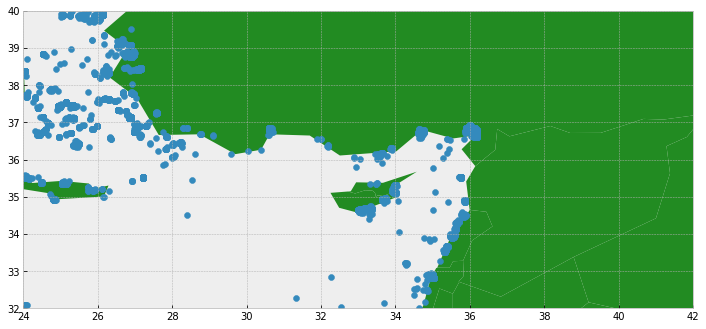

In [83]:
plt.figure(figsize=(12,12))
aoi.plot(color="forestgreen", ax=plt.gca())
locations_eastmediterranean.plot(ax=plt.gca())

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

In [358]:
locs = locations_eastmediterranean.copy()
locs["component"] = -1
locs["cell_x"] = (locs["easting"] / THR).astype(int)
locs["cell_y"] = (locs["northing"] / THR).astype(int)

In [359]:
locs.head()

,easting,northing,zone_number,zone_letter,lat,lon,W,E,S,N,component,geometry,cell_x,cell_y
452,359042.859521,4.028304e+06,35,S,36.38955,25.42832,0,0,0,0,-1,POINT (25.42832 36.38955),35,402
455,359222.293519,4.028249e+06,35,S,36.38908,25.43033,0,0,0,0,-1,POINT (25.43033 36.38908),35,402
457,318285.792025,4.144882e+06,35,S,37.43294,24.94613,0,0,0,0,-1,POINT (24.94613 37.43294),31,414
459,512644.892559,4.057884e+06,35,S,36.66648,27.14150,0,0,0,0,-1,POINT (27.14150 36.66648),51,405
462,279779.571833,4.113606e+06,35,S,37.14293,24.52051,0,0,0,0,-1,POINT (24.52051 37.14293),27,411


In [360]:
locs["border"] = (locs[["N", "E", "S", "W"]].sum(axis=1)!=0).astype(int)

In [361]:
locs

,easting,northing,zone_number,zone_letter,lat,lon,W,E,S,N,component,geometry,cell_x,cell_y,border
452,359042.859521,4.028304e+06,35,S,36.38955,25.42832,0,0,0,0,-1,POINT (25.42832 36.38955),35,402,0
455,359222.293519,4.028249e+06,35,S,36.38908,25.43033,0,0,0,0,-1,POINT (25.43033 36.38908),35,402,0
457,318285.792025,4.144882e+06,35,S,37.43294,24.94613,0,0,0,0,-1,POINT (24.94613 37.43294),31,414,0
459,512644.892559,4.057884e+06,35,S,36.66648,27.14150,0,0,0,0,-1,POINT (27.14150 36.66648),51,405,0
462,279779.571833,4.113606e+06,35,S,37.14293,24.52051,0,0,0,0,-1,POINT (24.52051 37.14293),27,411,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493706,492254.835523,4.292446e+06,35,S,38.78071,26.91083,0,0,0,0,-1,POINT (26.91083 38.78071),49,429,0
1493786,733958.755713,3.754938e+06,36,S,33.90890,35.53044,0,0,0,0,-1,POINT (35.53044 33.90890),73,375,0
1493844,736586.372615,3.757294e+06,36,S,33.92954,35.55947,0,0,0,0,-1,POINT (35.55947 33.92954),73,375,0
1493868,733959.968792,3.754814e+06,36,S,33.90778,35.53042,0,0,0,0,-1,POINT (35.53042 33.90778),73,375,0


In [362]:
zone_grp = locs.groupby(["zone_number", "zone_letter"])

kdtrees = {}

for zone, zone_locations in tqdm.tqdm(zone_grp, total=len(zone_grp.groups)):
    zn, zl = zone
    zone_mask = (locations_utm.zone_number==zn) & (locations_utm.zone_letter==zl)
    tree = cKDTree(locations_utm.loc[zone_mask, ["easting", "northing"]].values)
    kdtrees[zone] = [locations_utm.loc[zone_mask].index, tree]

100%|██████████| 3/3 [00:00<00:00, 11.83it/s]


In [236]:
c = ConnectedComponent(0, locs, THR)
c.add(452)

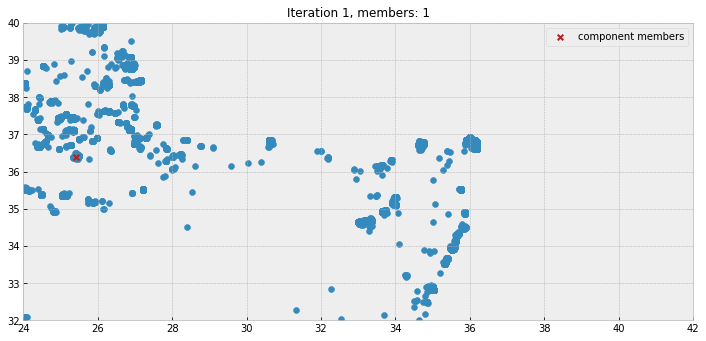

In [237]:
plt.figure(figsize=(12,12))
locs.plot(ax=plt.gca())
locs.loc[c.elements].plot(c="firebrick", ax=plt.gca(), marker="x", markersize=32, label="component members")

plt.legend(loc=0)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

plt.title(f"Iteration 1, members: {c.size}", fontsize=12);

In [164]:
c.grow(locs)
c.size, c.is_full(), len(c.members.difference(c.visited))

(133, False, 132)

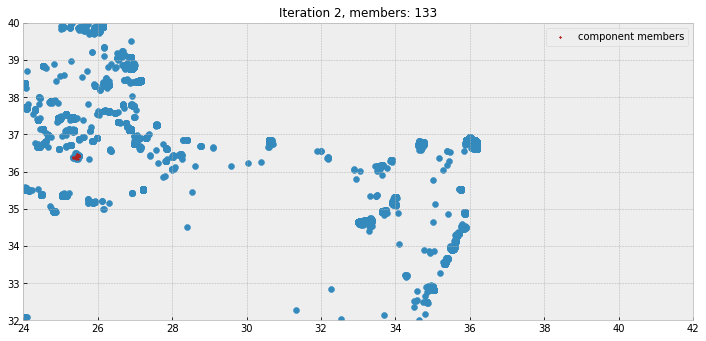

In [165]:
plt.figure(figsize=(12,12))
locs.plot(ax=plt.gca())
locs.loc[c.elements].plot(c="firebrick", ax=plt.gca(), marker="x", markersize=1, label="component members")

plt.legend(loc=0)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

plt.title(f"Iteration 2, members: {c.size}", fontsize=12);

In [166]:
c.grow(locs)
c.size, c.is_full(), len(c.members.difference(c.visited))

(136, False, 3)

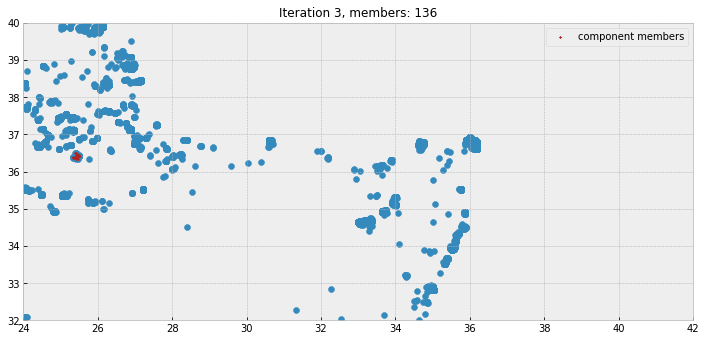

In [167]:
plt.figure(figsize=(12,12))
locs.plot(ax=plt.gca())
locs.loc[c.elements].plot(c="firebrick", ax=plt.gca(), marker="x", markersize=1, label="component members")

plt.legend(loc=0)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

plt.title(f"Iteration 3, members: {c.size}", fontsize=12);

In [168]:
c.grow(locs)
c.size, c.is_full()

(136, True)

In [372]:
%%time

THR = 10000
locs["component"] = -1
current_cid = -1
components = {}

while (locs.component==-1).sum()!=0:
    current_cid += 1
    zones_to_update = set()
    # TODO: add weights, use more connected locations first
    seed = locs[locs.component==-1].sample(1).index[0]

    zn, zl = locs.loc[seed, ["zone_number", "zone_letter"]]
    zone_mask = (locs.zone_number==zn) & (locs.zone_letter==zl)

    component = ConnectedComponent(current_cid, locs, THR)
    component.add(seed)
    locs.loc[seed, "component"] = current_cid

    print(f"Starting new component {component.cid}")

    while not component.is_full():
        component_mask = locs.component==-1

        if not locs.loc[zone_mask & component_mask].empty:
            kdtrees[(zn, zl)] = [locs.loc[zone_mask & component_mask].index,
                                 cKDTree(locs.loc[zone_mask & component_mask,
                                                  ["easting", "northing"]].values)]

            for (lzn, lzl) in zones_to_update:
                local_zone_mask = (locs.zone_number==lzn) & (locs.zone_letter==lzl)
                zone_tree = cKDTree(locs.loc[local_zone_mask & component_mask,
                                             ["easting", "northing"]].values)
                kdtrees[(lzn, lzl)] = [locs.loc[local_zone_mask & component_mask].index, zone_tree]

            zones_to_update = component.grow(kdtrees=kdtrees)
        else:
            component.grow(locs=locs)
        locs.loc[component.elements, "component"] = current_cid
        print(f"\tGrowing {component.cid}: {component.size}")

    components[component.cid] = component.elements

Starting new component 0
	Growing 0: 2054
	Growing 0: 2132
	Growing 0: 2134
	Growing 0: 2134
Starting new component 1
	Growing 1: 2152
	Growing 1: 2293
	Growing 1: 2297
	Growing 1: 2297
Starting new component 2
	Growing 2: 288
	Growing 2: 293
	Growing 2: 323
	Growing 2: 1002
	Growing 2: 1002
Starting new component 3
	Growing 3: 3127
	Growing 3: 3251
	Growing 3: 3255
	Growing 3: 3255
Starting new component 4
	Growing 4: 919
	Growing 4: 921
	Growing 4: 923
	Growing 4: 923
Starting new component 5
	Growing 5: 448
	Growing 5: 451
	Growing 5: 451
Starting new component 6
	Growing 6: 175
	Growing 6: 176
	Growing 6: 176
Starting new component 7
	Growing 7: 181
	Growing 7: 201
	Growing 7: 252
	Growing 7: 252
Starting new component 8
	Growing 8: 89
	Growing 8: 89
Starting new component 9
	Growing 9: 184
	Growing 9: 189
	Growing 9: 189
Starting new component 10
	Growing 10: 538
	Growing 10: 673
	Growing 10: 1418
	Growing 10: 2703
	Growing 10: 3015
	Growing 10: 3015
Starting new component 11
	Gro

In [373]:
locs[locs.component==-1]

,easting,northing,zone_number,zone_letter,lat,lon,W,E,S,N,component,geometry,cell_x,cell_y,border


In [374]:
locs.component.value_counts()

3      3255
10     3015
1      2297
0      2134
2      1002
       ... 
154       1
138       1
122       1
106       1
155       1
Name: component, Length: 168, dtype: int64

Text(0.5, 1.0, 'Components sizes (ordered)')

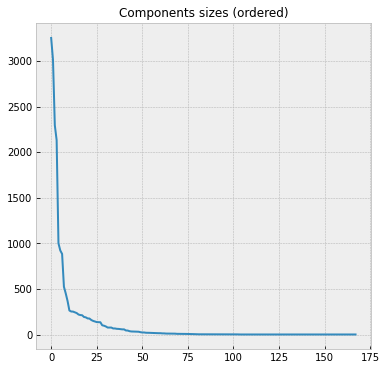

In [375]:
plt.figure(figsize=(6,6))

locs.component.value_counts().reset_index(drop=True).plot()
plt.title("Components sizes (ordered)", fontsize=12)

In [293]:
locs.component.value_counts().cumsum()

0       3255
2       6270
10      8567
6      10701
3      11703
       ...  
164    20091
148    20092
132    20093
152    20094
159    20095
Name: component, Length: 168, dtype: int64

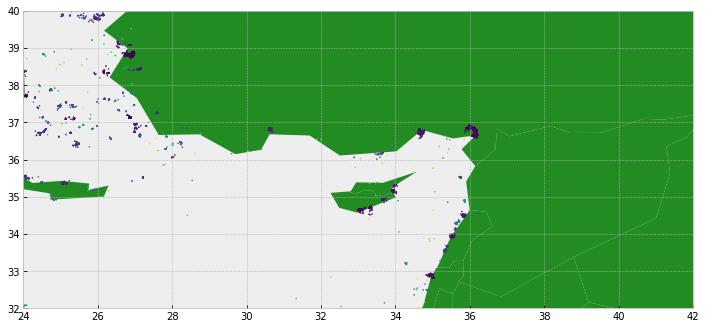

In [294]:
plt.figure(figsize=(12,12))
aoi.plot(color="forestgreen", ax=plt.gca())
locs.plot(column="component", ax=plt.gca(), s=1)

plt.xlim(minx, maxx)
plt.ylim(miny, maxy);

Let's check components we know to be cross-zone. We have Dörtyol-İskenderun cluster in this group:

(36.0, 37.0)

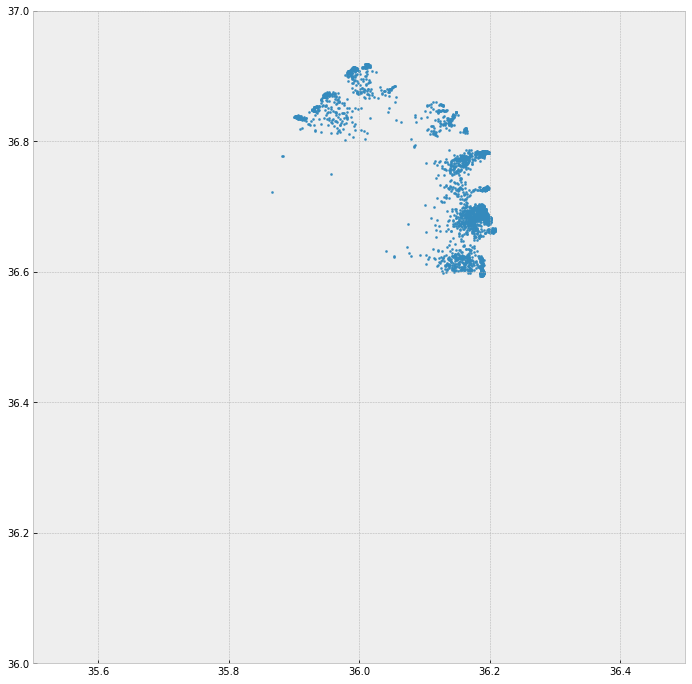

In [378]:
plt.figure(figsize=(12,12))
locs[locs.component==10].plot(ax=plt.gca(), markersize=4)

plt.xlim(35.5, 36.5)
plt.ylim(36, 37)

This one is correct.

# Full computation

In [190]:
import time

In [191]:
locations_utm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494055 entries, 0 to 1494054
Data columns (total 11 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   easting      1494055 non-null  float64
 1   northing     1494055 non-null  float64
 2   zone_number  1494055 non-null  int64  
 3   zone_letter  1494055 non-null  object 
 4   lat          1494055 non-null  float64
 5   lon          1494055 non-null  float64
 6   W            1494055 non-null  int64  
 7   E            1494055 non-null  int64  
 8   S            1494055 non-null  int64  
 9   N            1494055 non-null  int64  
 10  component    1494055 non-null  int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 125.4+ MB


In [379]:
locs = locations_utm.copy()
locs["component"] = -1
locs["cell_x"] = (locs["easting"] / THR).astype(int)
locs["cell_y"] = (locs["northing"] / THR).astype(int)
locs["border"] = (locs[["N", "E", "S", "W"]].sum(axis=1)!=0).astype(int)

In [380]:
locs

,easting,northing,zone_number,zone_letter,lat,lon,W,E,S,N,component,cell_x,cell_y,border
0,551130.048588,4.720932e+06,54,T,42.63914,141.62366,0,0,0,0,-1,55,472,0
1,465345.985460,4.031530e+06,54,S,36.42835,140.61340,0,0,0,0,-1,46,403,0
2,551274.751185,4.720877e+06,54,T,42.63864,141.62542,0,0,0,0,-1,55,472,0
3,465364.250731,4.031614e+06,54,S,36.42911,140.61360,0,0,0,0,-1,46,403,0
4,465426.304542,4.031665e+06,54,S,36.42957,140.61429,0,0,0,0,-1,46,403,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494050,623895.533982,9.867330e+06,53,M,-1.20008,136.11359,0,0,0,0,-1,62,986,0
1494051,748099.313672,2.878732e+06,50,R,26.00627,119.47872,0,0,0,0,-1,74,287,0
1494052,732699.823056,3.754390e+06,36,S,33.90424,35.51669,0,0,0,0,-1,73,375,0
1494053,215096.239204,2.491892e+06,51,Q,22.50978,120.23062,0,0,0,0,-1,21,249,0


In [381]:
THR

10000

In [383]:
zone_grp = locs.groupby(["zone_number", "zone_letter"])

kdtrees = {}

for zone, zone_locations in tqdm.tqdm(zone_grp, total=len(zone_grp.groups)):
    zn, zl = zone
    zone_mask = (locations_utm.zone_number==zn) & (locations_utm.zone_letter==zl)
    tree = cKDTree(locations_utm.loc[zone_mask, ["easting", "northing"]].values)
    kdtrees[zone] = [locations_utm.loc[zone_mask].index, tree]

100%|██████████| 437/437 [00:38<00:00, 11.23it/s]


In [384]:
%%time

locs["component"] = -1
current_cid = -1
components = {}
timings = []

global_start_t = time.time()

while (locs.component==-1).sum()!=0:
    start_t = time.time()
    current_cid += 1
    zones_to_update = set()

    # TODO: add weights, use more connected locations first
    seed = locs[locs.component==-1].sample(1).index[0]

    zn, zl = locs.loc[seed, ["zone_number", "zone_letter"]]
    zone_mask = (locs.zone_number==zn) & (locs.zone_letter==zl)

    component = ConnectedComponent(current_cid, locs, THR)
    component.add(seed)
    locs.loc[seed, "component"] = current_cid

    print(f"""Starting new component {component.cid} in {locs.loc[seed, 'zone_number']}{locs.loc[seed, 'zone_letter']}, """
          f"""unmarked locations: {(locs.component==-1).sum()} out of {locs.shape[0]}""")

    while not component.is_full():
        component_mask = locs.component==-1
        if not locs.loc[zone_mask & component_mask].empty:
            kdtrees[(zn, zl)] = [locs.loc[zone_mask & component_mask].index,
                                 cKDTree(locs.loc[zone_mask & component_mask,
                                                  ["easting", "northing"]].values)]

            for (lzn, lzl) in zones_to_update:
                local_zone_mask = (locs.zone_number==lzn) & (locs.zone_letter==lzl)
                zone_tree = cKDTree(locs.loc[local_zone_mask & component_mask,
                                             ["easting", "northing"]].values)
                kdtrees[(lzn, lzl)] = [locs.loc[local_zone_mask & component_mask].index, zone_tree]

            zones_to_update = component.grow(kdtrees=kdtrees)
        else:
            component.grow(locs=locs)
        locs.loc[component.elements, "component"] = current_cid
        print(f"\tGrowing {component.cid}: {component.size}")

    components[component.cid] = component.elements

    end_t = time.time()
    print(f"Elapsed: {(end_t - global_start_t)/60:.2f}m")
    timings.append([component.size, end_t - start_t])

Starting new component 0 in 31U, unmarked locations: 1494054 out of 1494055
	Growing 0: 17622
	Growing 0: 30114
	Growing 0: 45199
	Growing 0: 50731
	Growing 0: 51501
	Growing 0: 52096
	Growing 0: 52458
	Growing 0: 52532
	Growing 0: 52655
	Growing 0: 52815
	Growing 0: 53346
	Growing 0: 53487
	Growing 0: 53822
	Growing 0: 54065
	Growing 0: 54522
	Growing 0: 55836
	Growing 0: 56457
	Growing 0: 62815
	Growing 0: 63458
	Growing 0: 64035
	Growing 0: 64159
	Growing 0: 65685
	Growing 0: 66543
	Growing 0: 67945
	Growing 0: 68312
	Growing 0: 68481
	Growing 0: 68911
	Growing 0: 69325
	Growing 0: 69920
	Growing 0: 71032
	Growing 0: 71264
	Growing 0: 71273
	Growing 0: 71306
	Growing 0: 71316
	Growing 0: 71339
	Growing 0: 71441
	Growing 0: 71592
	Growing 0: 71710
	Growing 0: 71725
	Growing 0: 71728
	Growing 0: 71736
	Growing 0: 71754
	Growing 0: 71837
	Growing 0: 71839
	Growing 0: 71865
	Growing 0: 71972
	Growing 0: 72290
	Growing 0: 72354
	Growing 0: 72515
	Growing 0: 72611
	Growing 0: 72710
	Growi

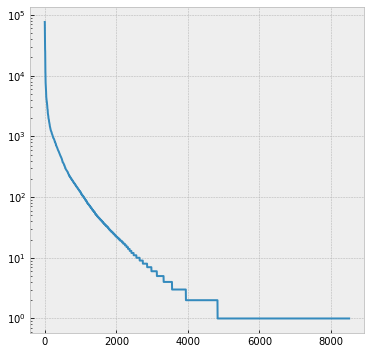

In [406]:
plt.figure(figsize=(6,6))
locs.component.value_counts().reset_index(drop=True).plot()
plt.yscale("log")

In [393]:
locs.to_csv(DATA_DIR.joinpath("locations_components.csv"), index=False)

In [396]:
timings = pd.DataFrame(timings, columns=["component_size", "time"])

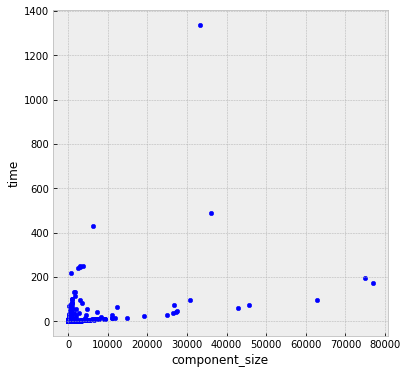

In [408]:
plt.figure(figsize=(6,6))

timings.plot(x="component_size", y="time", kind="scatter", ax=plt.gca())

In [399]:
timings[timings.time>200].sum()

component_size    88319.000000
time               3464.451357
dtype: float64

In [400]:
3466/60

57.766666666666666

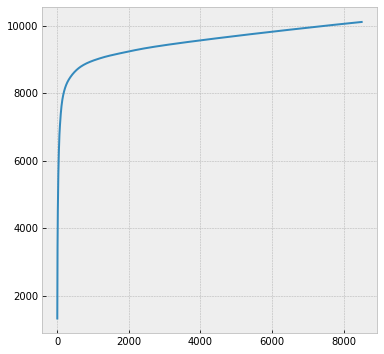

In [409]:
plt.figure(figsize=(6,6))

timings.sort_values("time", ascending=False)["time"].cumsum().reset_index(drop=True).plot()

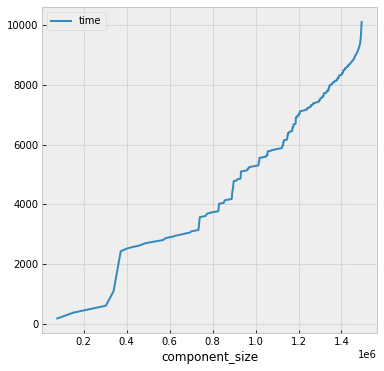

In [415]:
plt.figure(figsize=(6,6))
timings.sort_values("component_size", ascending=False).cumsum().plot(x="component_size", y="time", ax=plt.gca())

#### Slowest components

In [416]:
timings[timings.time>200]

,component_size,time
46,33293,1337.286547
47,6143,428.974101
50,35952,488.564911
84,3061,251.411420
105,2939,246.337265
352,3752,252.004489
596,2369,241.663934
902,810,218.208689


In [418]:
timings.sort_values("component_size", ascending=False).head(15)

,component_size,time
2,76830,175.119685
0,74982,196.109750
22,62709,97.525957
1,45674,72.534117
37,42817,61.519534
50,35952,488.564911
46,33293,1337.286547
42,30836,94.720504
12,27561,49.044740
44,27288,43.011233


In [421]:
locs.component.value_counts().head(15)

2      76830
0      74982
22     62709
1      45674
37     42817
50     35952
46     33293
42     30836
12     27561
44     27288
49     26694
9      26412
25     24959
133    19035
28     14753
Name: component, dtype: int64

In [422]:
locs[locs.component==46]

,easting,northing,zone_number,zone_letter,lat,lon,W,E,S,N,component,cell_x,cell_y,border
1710,752270.544462,3.568228e+06,50,S,32.22237,119.67685,0,0,0,0,46,75,356,0
1712,303092.507841,3.530891e+06,51,R,31.89683,120.91787,0,0,0,0,46,30,353,0
1713,238900.980908,3.536720e+06,51,R,31.93643,120.23812,0,0,0,1,46,23,353,1
1717,752156.889230,3.567868e+06,50,S,32.21915,119.67555,0,0,0,0,46,75,356,0
1890,748588.586232,3.565091e+06,50,S,32.19492,119.63700,0,0,0,0,46,74,356,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493969,758110.368816,3.579824e+06,50,S,32.32554,119.74190,0,0,0,0,46,75,357,0
1493970,353237.184413,3.443413e+06,51,R,31.11543,121.46090,0,0,0,0,46,35,344,0
1493972,270158.336548,3.542671e+06,51,R,31.99683,120.56707,0,0,0,1,46,27,354,1
1494001,293759.678614,3.545111e+06,51,S,32.02337,120.81621,0,0,1,0,46,29,354,1


In [426]:
locs

,easting,northing,zone_number,zone_letter,lat,lon,W,E,S,N,component,cell_x,cell_y,border
0,551130.048588,4.720932e+06,54,T,42.63914,141.62366,0,0,0,0,41,55,472,0
1,465345.985460,4.031530e+06,54,S,36.42835,140.61340,0,0,0,0,568,46,403,0
2,551274.751185,4.720877e+06,54,T,42.63864,141.62542,0,0,0,0,41,55,472,0
3,465364.250731,4.031614e+06,54,S,36.42911,140.61360,0,0,0,0,568,46,403,0
4,465426.304542,4.031665e+06,54,S,36.42957,140.61429,0,0,0,0,568,46,403,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494050,623895.533982,9.867330e+06,53,M,-1.20008,136.11359,0,0,0,0,572,62,986,0
1494051,748099.313672,2.878732e+06,50,R,26.00627,119.47872,0,0,0,0,664,74,287,0
1494052,732699.823056,3.754390e+06,36,S,33.90424,35.51669,0,0,0,0,707,73,375,0
1494053,215096.239204,2.491892e+06,51,Q,22.50978,120.23062,0,0,0,0,14,21,249,0


In [428]:
problematic_component = gpd.GeoDataFrame(locs[locs.component==46],
                                         geometry=gpd.points_from_xy(locs.loc[locs.component==46, "lon"],
                                                                     locs.loc[locs.component==46, "lat"]),
                                         crs="EPSG:4326")

In [431]:
problematic_component.groupby(["zone_number", "zone_letter"]).size()

zone_number  zone_letter
50           R               1034
             S               5749
51           R              23781
             S               2729
dtype: int64

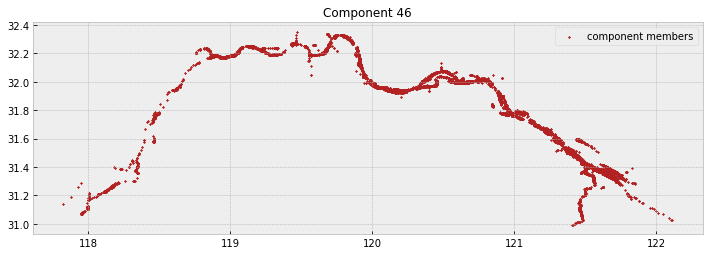

In [429]:
plt.figure(figsize=(12,12))
problematic_component.plot(c="firebrick", ax=plt.gca(), marker="x", markersize=1, label="component members")

plt.legend(loc=0)

plt.title("Component 46", fontsize=12);

It's a river.